In [4]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import models, transforms

# Improving Performance with Data Augmentation

In this tutorial, you will learn how to use data augmentation techniques to expand the set of available training data and significantly improve the performance of the standard LeNet5 CNN developed in the [previous tutorial](./notebooks/mnist-tutorial).


# Load the CIFAR-10 data

In [5]:
DATA_DIR = pathlib.Path("../data/")
RAW_DATA_DIR = DATA_DIR / "cifar-10"

train_df = pd.read_csv(RAW_DATA_DIR / "train.csv", dtype="uint8")
test_df = pd.read_csv(RAW_DATA_DIR / "test.csv", dtype="uint8")

In [10]:
train_features = train_df.drop("labels", axis=1)
train_target = train_df.loc[:, "labels"]

## Create custom `DataSet` class to handle transformations

In [8]:
class DataSetWithTransforms(data.Dataset):
    
    def __init__(self, features, target, feature_transforms=None):
        super().__init__()
        self._features = features
        self._target = torch.from_numpy(target).long()
        self._feature_transforms = feature_transforms
        
    def __getitem__(self, index):
        if self._feature_transforms is None:
            features = self._features[index]
        else: 
            features = self._feature_transforms(self._features[index])
        target = self._target[index]
        return (features, target) 
    
    def __len__(self):
        n_samples, _ = self._features.shape
        return n_samples


In [12]:
# data augmentation should only apply to training data
_feature_transforms = transforms.Compose([
    transforms.Lambda(lambda array: array.reshape((3, 32, 32)).transpose(1,2,0)),
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=15, scale=(1.0, 1.1)),
    transforms.ToTensor(),
])

train_dataset = DataSetWithTransforms(train_features.values, train_target.values, _feature_transforms)


In [ ]:
train_dataset = data.TensorDataset(preprocessed_train_features, preprocessed_train_target)


In [ ]:
# data augmentation should not be applied to validation data
_feature_transforms = transforms.Compose([
    transforms.Lambda(lambda array: array.reshape((28, 28, 1))),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

validation_dataset = DataSetWithTransforms(validation_features, validation_target, _feature_transforms)

## Create a custom DataLoader for training and validation datasets

In [13]:
class WrappedDataLoader:
    
    def __init__(self, data_loader, f):
        self._data_loader = data_loader
        self._f = f
        
    def __len__(self):
        return len(self._data_loader)
    
    def __iter__(self):
        for batch in iter(self._data_loader):
            yield self._f(*batch)

In [15]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

_batch_size = 32
_train_data_loader = data.DataLoader(train_dataset, batch_size=_batch_size, shuffle=True)
train_data_loader = WrappedDataLoader(_train_data_loader, lambda X, y: (X.to(DEVICE), y.to(DEVICE)))
#_validation_data_loader = data.DataLoader(validation_dataset, batch_size=1024)
#validation_data_loader = WrappedDataLoader(_validation_data_loader, lambda X, y: (X.to(DEVICE), y.to(DEVICE)))


# Exploring transformed images

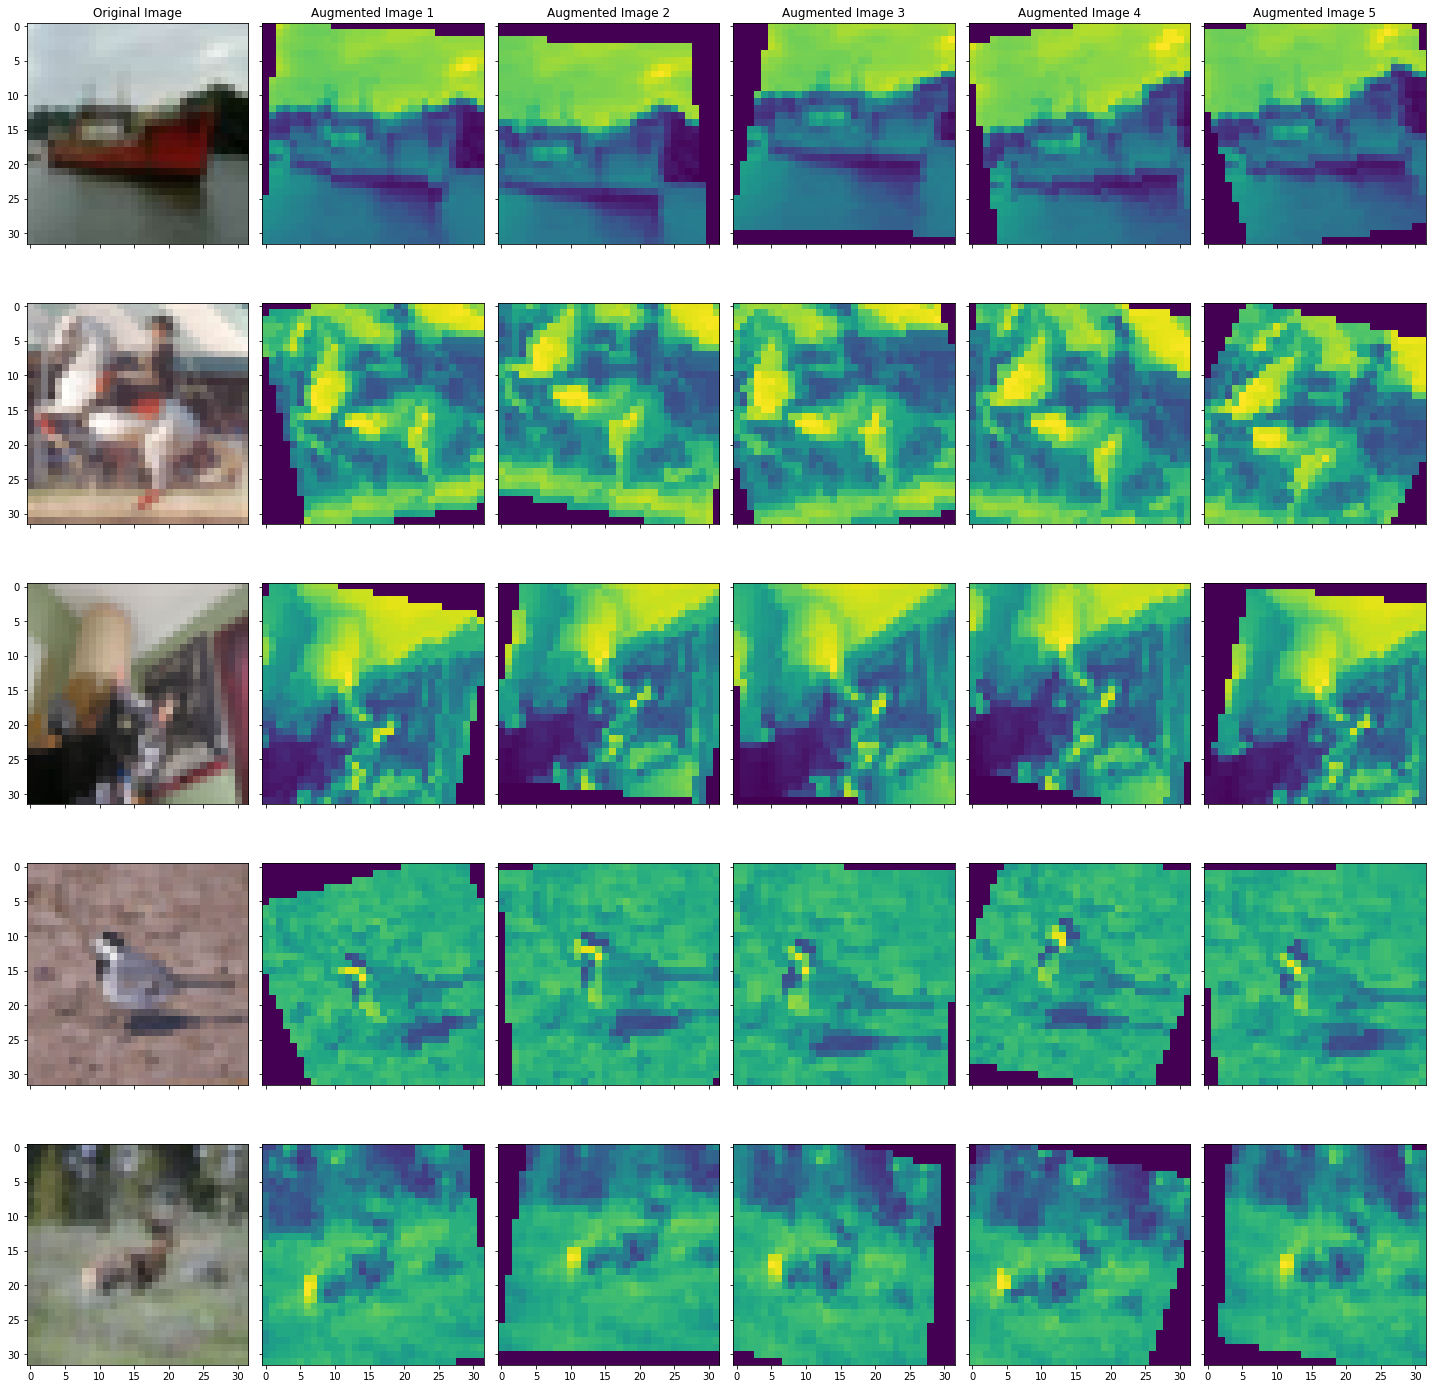

In [21]:
fig, axes = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(20, 20))
for i in range(5):
    for j in range(6):
        if j == 0:
            _ = axes[i, j].imshow(train_features.values[i].reshape((3, 32, 32)).transpose(1,2,0))
        else:
            _ = axes[i, j].imshow(train_dataset[i][0][0])
        
        if i == 0 and j == 0:
            axes[i, j].set_title("Original Image")
        if i == 0 and j > 0:
            axes[i, j].set_title(f"Augmented Image {j}")        
fig.tight_layout()

# Train a CNN

In [ ]:
def _checkpoint(epoch, model_fn, opt, path):
    kwargs = {"epoch": epoch,
              "model_state_dict": model_fn.state_dict(),
              "optimizer_state_dict": opt.state_dict()}
    torch.save(kwargs, path)


def _partial_fit(model_fn, loss_fn, X_batch, y_batch, opt):
    # forward pass
    loss = loss_fn(model_fn(X_batch), y_batch)

    # back propagation
    loss.backward()
    opt.step()
    opt.zero_grad() # don't forget to reset the gradient after each batch!


def fit(model_fn, loss_fn, training_data_loader, opt, validation_data_loader=None, number_epochs=1, path="checkpoint.pkl"):
    lowest_validation_loss = np.inf # initialize validation loss for checkpointing!
    for epoch in range(number_epochs):
        model_fn.train()
        for X_batch, y_batch in training_data_loader:
            _partial_fit(model_fn, loss_fn, X_batch, y_batch, opt)
        
        # compute validation loss after each training epoch
        if validation_data_loader is not None:
            model_fn.eval()
            with torch.no_grad():
                batch_losses, batch_sizes = zip(*[(loss_fn(model_fn(X), y), len(X)) for X, y in validation_data_loader])
                validation_loss = np.sum(np.multiply(batch_losses, batch_sizes)) / np.sum(batch_sizes)
                if validation_loss < lowest_validation_loss:
                    print(f"Training epoch: {epoch}, Lowest validation loss: {validation_loss}")
                    _checkpoint(epoch, model_fn, opt, path)
                    lowest_validation_loss = validation_loss
        print(f"Completed {epoch} out of {number_epochs} training epochs.")


In [ ]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)
    

In [ ]:
lenet5 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    LambdaLayer(lambda X: X.view(X.size(0), -1)),
    nn.Linear(256, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
lenet5.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

opt = optim.Adam(lenet5.parameters())

In [ ]:
fit(lenet5, loss_fn, training_data_loader, opt, validation_data_loader, number_epochs=100)

## Make predictions using the test data

### Load the testing data

In [ ]:
_testing_features = np.loadtxt("../input/test.csv", delimiter=',', skiprows=1, dtype=np.int64)
_scaled_testing_features = np.divide(_testing_features, 255, dtype=np.float32)
scaled_testing_features_tensor = torch.from_numpy(_scaled_testing_features)

### Reset the model parameters using the checkpoint

In [ ]:
checkpoint = torch.load("checkpoint.pkl")
lenet5.load_state_dict(checkpoint["model_state_dict"])
lenet5.eval()

In [ ]:
output = lenet5(scaled_testing_features_tensor.view(-1, 1, 28, 28).to(DEVICE))
predictions = torch.argmax(output, dim=1)

## Visually check model predictions

In [ ]:
fig , axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
idx = 0
for i  in range(5):
    for j in range(5):
        _ = axes[i, j].imshow(scaled_testing_features_tensor[idx].reshape((28, 28)), cmap="gray")
        axes[i, j].set_title(f"Predicted digit: {predictions[idx]}")
        idx += 1
fig.tight_layout()

## Reformat predictions

In [ ]:
# submission format for kaggle
!head ../input/sample_submission.csv

In [ ]:
import time

import pandas as pd

timestamp = time.strftime("%Y%m%d-%H%M%S")
number_predictions, = predictions.shape
(pd.DataFrame({"ImageId": range(1, number_predictions + 1), "Label": predictions.cpu()})
   .to_csv(f"submission-{timestamp}.csv", index=False))

In [ ]:
!head submission-*.csv

## Submit to Kaggle!

Once you have successfully submited your predictions then you can check the [Digit-Recognizer competition](https://www.kaggle.com/c/digit-recognizer) website and see how well your best model compares to your peers.

In [ ]:
%%bash
export KAGGLE_USERNAME="YOUR_USERNAME"
export KAGGLE_KEY="YOUR_API_KEY"
kaggle competitions submit digit-recognizer \
  -f $(ls ../data/kaggle-submissions/mnist/submission-*.csv | tail -n 1) \
  -m "My first digit recognizer submission!"